# Env setupu

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import plotly.express as px
from anndata import AnnData
from sklearn.neighbors import KernelDensity
import random
from matplotlib import pylab
from matplotlib.colors import TwoSlopeNorm

import warnings
import scanpy.external as sce 
import yaml

import seaborn as sns
import os
import sys

warnings.filterwarnings('ignore')

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
sc.settings.verbosity = 3  
sc.logging.print_header()
nprocs=4
np.random.seed(0)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor white
dotSize 20


# Configure paths

In [7]:
outdir = "../data/output"

with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
colorsmap = dict(zip([i["newName"] for i in iPSC_lines_map.values()],[i["color"] for i in iPSC_lines_map.values()]))


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)
    
#tradeSeqUtilsPath = "/opt/tradeSeq_utils.R"
tradeSeqUtilsPath = "/opt/tradeSeq_utils.R"

# var setting

In [8]:
branchTag = "Cajal"
endpoint = "endpoint_CajalR_like"
markers = ["RELN","PAX6","CBLN1","MKI67"]
min_cells = 50
MultiTPTstages = ["early","mid"]
binWidthRate = .05
ResamplingIterations = 50
leidenOrder = ["ProliferatingProgenitors", 'RadialGliaProgenitors', 'Neurons','CajalR_like']


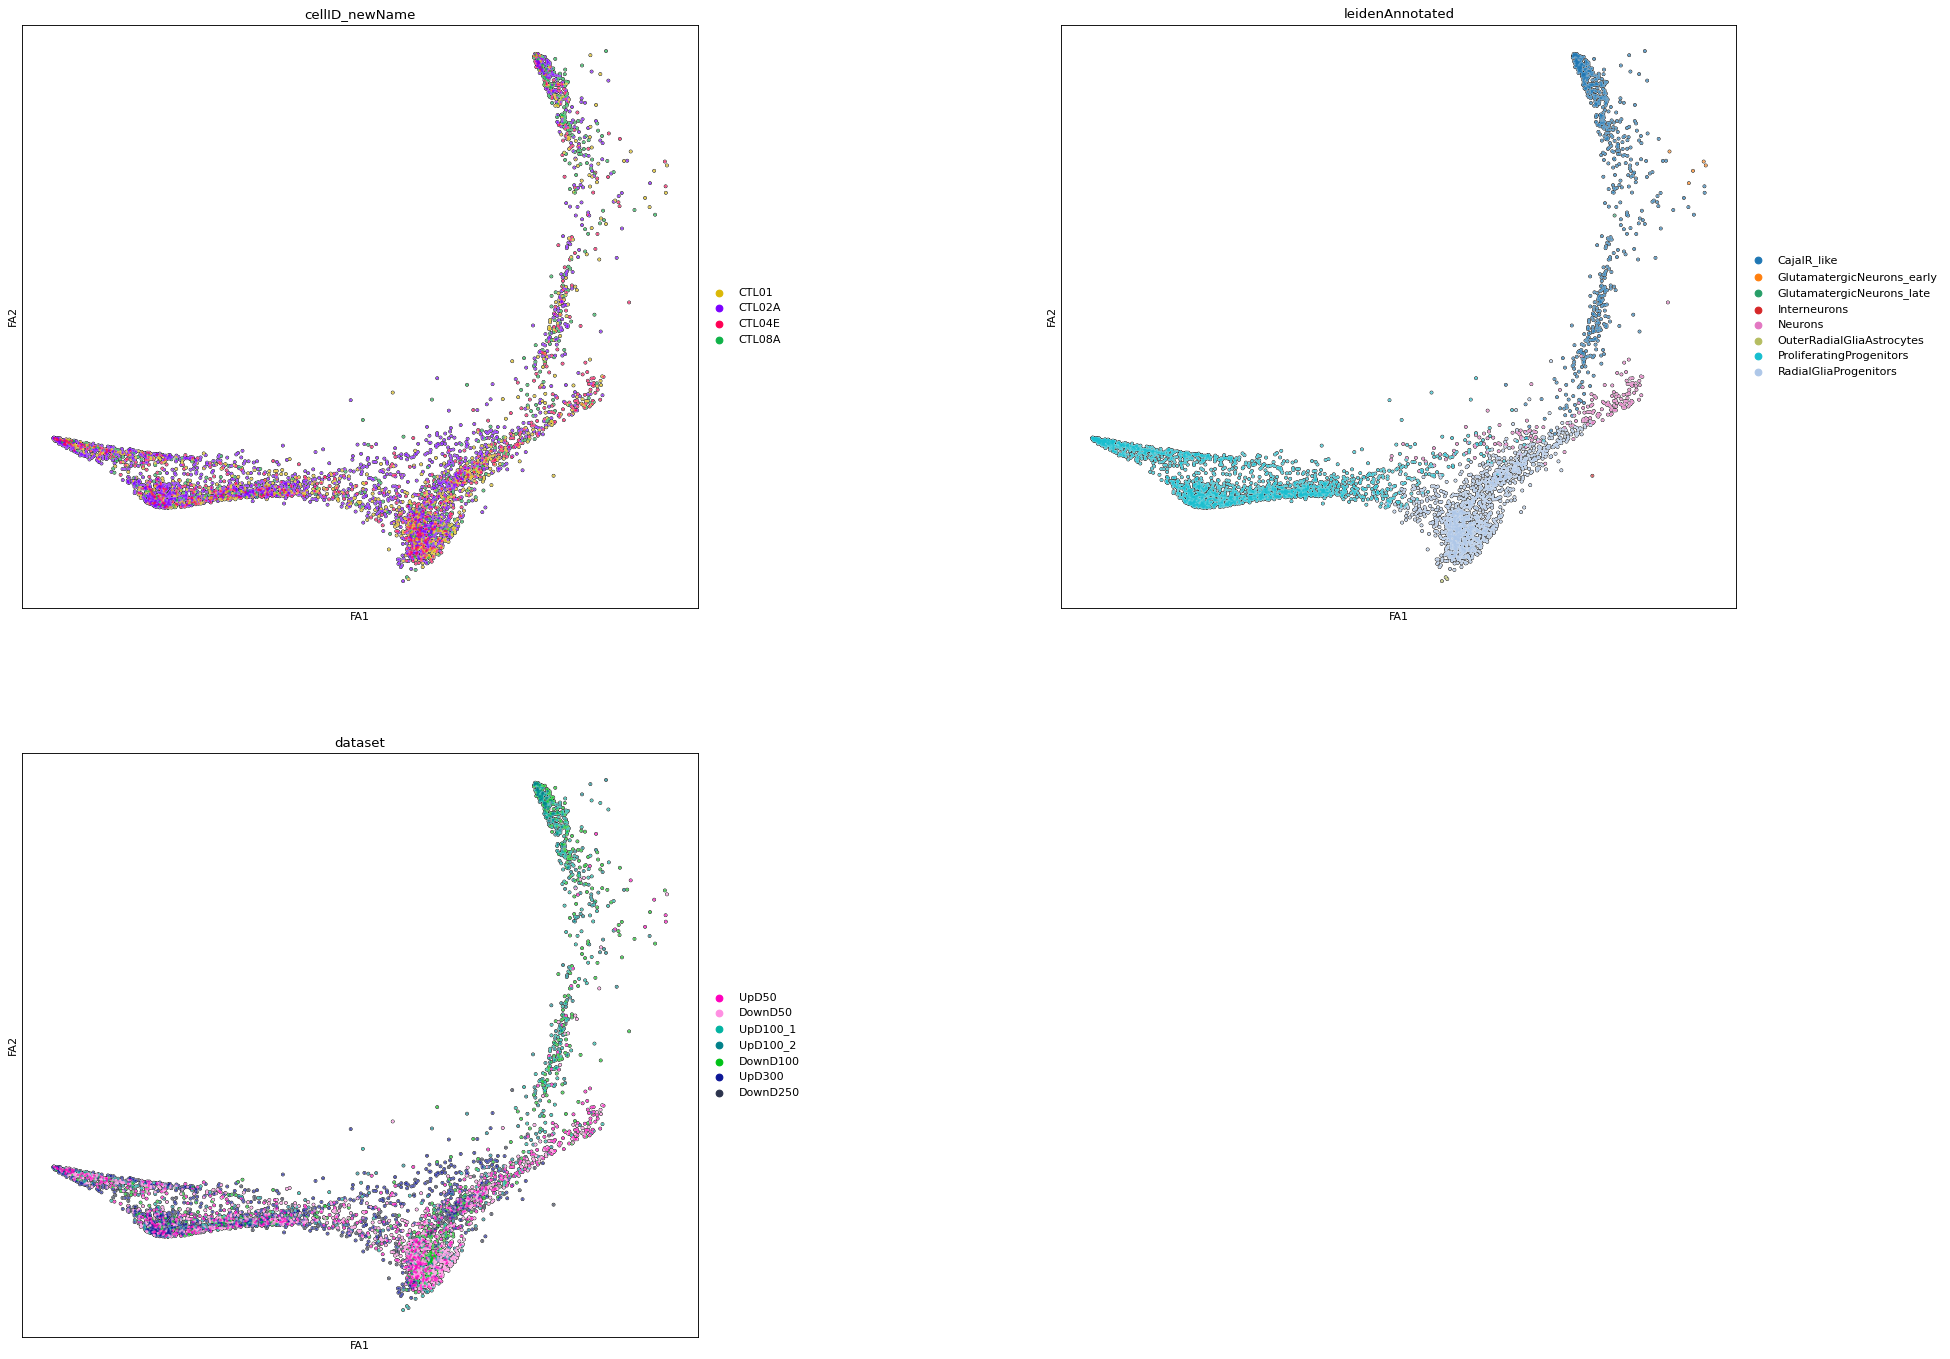

In [9]:
BranchBCs = sc.read_h5ad(outdir+"/adatas/adataPaga.h5ad")
sc.pl.draw_graph(BranchBCs[BranchBCs.obs[endpoint] == 1], color = ["cellID_newName","leidenAnnotated","dataset"], size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', wspace=.4, ncols=2)
BranchBCs = BranchBCs.obs_names[BranchBCs.obs[endpoint] == 1].tolist()

harmonyTheta = 1
HVGs=pd.read_csv(outdir+"/HVG_list_intersection_Curated_"+branchTag+"_PagaTest.txt", sep = "\t")["HVG"] 

## Branch specifi pre-processing

In [10]:
adataBranch = sc.read_h5ad(outdir+'/adatas/MultiplexingPreprocessing_unscaled.h5ad')[BranchBCs]
adataBranch.obs["leidenAnnotated"] =  sc.read_h5ad(outdir+"/adatas/ClusterAnnotated_Base_filt.h5ad")[adataBranch.obs_names].obs["leidenAnnotated"]
adataBranch.uns["leidenAnnotated_colors"] =  sc.read_h5ad(outdir+"/adatas/adataPaga.h5ad")[adataBranch.obs_names].uns["leidenAnnotated_colors"]
goodcls = adataBranch.obs.groupby(["leidenAnnotated"]).size()[adataBranch.obs.groupby(["leidenAnnotated"]).size() >= 50].index.tolist()
adataBranch = adataBranch[adataBranch.obs["leidenAnnotated"].isin(goodcls)]


adataBranch.layers["unscaled"] = adataBranch.X.copy()


sc.pp.normalize_total(adataBranch, target_sum=1e4)

sc.pp.log1p(adataBranch)
adataBranch.raw = adataBranch



adataBranch = adataBranch[:,HVGs]
adataBranch.var["highly_variable"] = True
#sc.pp.highly_variable_genes(adataBranch, min_mean=0.0125, max_mean=5, min_disp=0.5, batch_key = "dataset")

sc.pp.regress_out(adataBranch, ['total_counts','pct_counts_mt'], n_jobs=4)
sc.pp.scale(adataBranch, zero_center=False)
#adataBranch.X = adataBranch.X + np.abs(adataBranch.X.min())

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [11]:
sc.tl.pca(adataBranch, svd_solver='arpack', use_highly_variable=True)
sce.pp.harmony_integrate(adataBranch, 'dataset', max_iter_harmony=20,adjusted_basis="X_pca",random_state = 0, theta = harmonyTheta, lamb = 2)
sc.pp.neighbors(adataBranch,use_rep="X_pca",n_neighbors=50, n_pcs=10, random_state=0)

sc.tl.umap(adataBranch, random_state=0)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


2023-07-24 15:58:53,070 - harmonypy - INFO - Iteration 1 of 20
2023-07-24 15:58:54,790 - harmonypy - INFO - Iteration 2 of 20
2023-07-24 15:58:56,405 - harmonypy - INFO - Iteration 3 of 20
2023-07-24 15:58:58,237 - harmonypy - INFO - Iteration 4 of 20
2023-07-24 15:58:59,543 - harmonypy - INFO - Iteration 5 of 20
2023-07-24 15:59:00,394 - harmonypy - INFO - Iteration 6 of 20
2023-07-24 15:59:00,969 - harmonypy - INFO - Iteration 7 of 20
2023-07-24 15:59:02,085 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


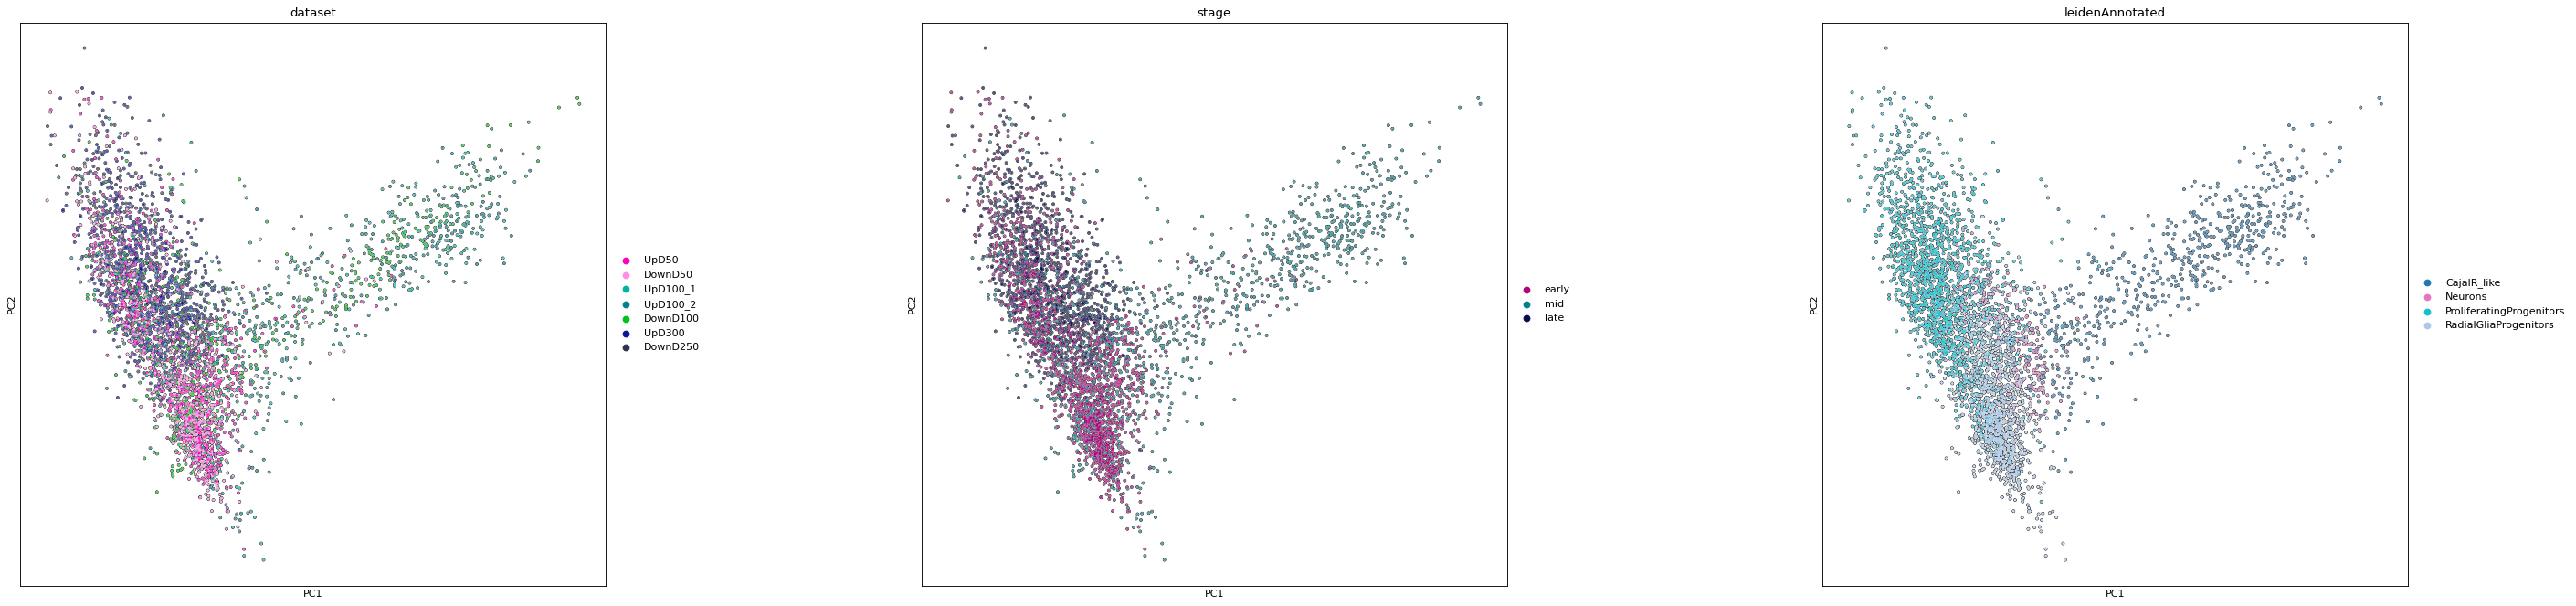

In [12]:
sc.pl.pca(adataBranch, color = ["dataset","stage",'leidenAnnotated'], size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98',wspace=.4)

# DPT

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9923771  0.981118   0.9725476  0.9649986  0.95886517
     0.95858294 0.93559384 0.92951417 0.92697394 0.89989907 0.89464426
     0.8909655  0.8848098  0.88005793]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


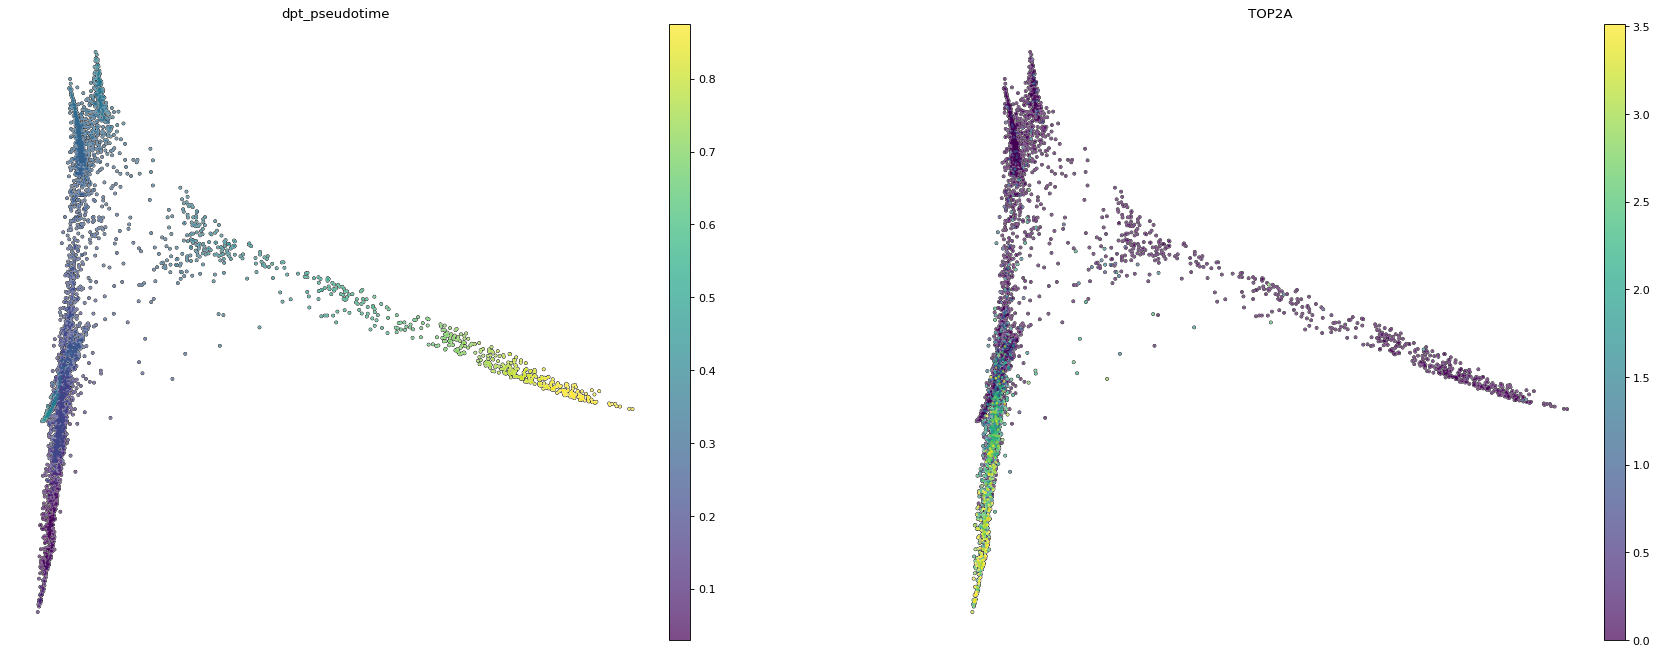

In [13]:
sc.tl.diffmap(adataBranch)


RootName = adataBranch.obs_names[adataBranch[:, ["TOP2A"]].X.argmax()]
root_idx = np.where(adataBranch.obs_names == RootName)[0][0]
adataBranch.uns['iroot'] = root_idx


sc.tl.dpt(adataBranch)
sc.pl.diffmap(adataBranch, color = ["dpt_pseudotime","TOP2A"],size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', legend_fontsize="xx-large", frameon=False, wspace=.3, legend_loc="on data")


In [14]:
adataBranch.write_h5ad(outdir+"/adatas/AdataLineage."+branchTag+".h5ad")

In [15]:
timeCov="dpt_pseudotime"
from matplotlib.pyplot import figure
sc.settings.set_figure_params(dpi=100)
pylab.rcParams['figure.figsize'] = (10, 8)

## By timepoint

In [16]:
sns.set_style("white")

In [17]:
cov = "stage"

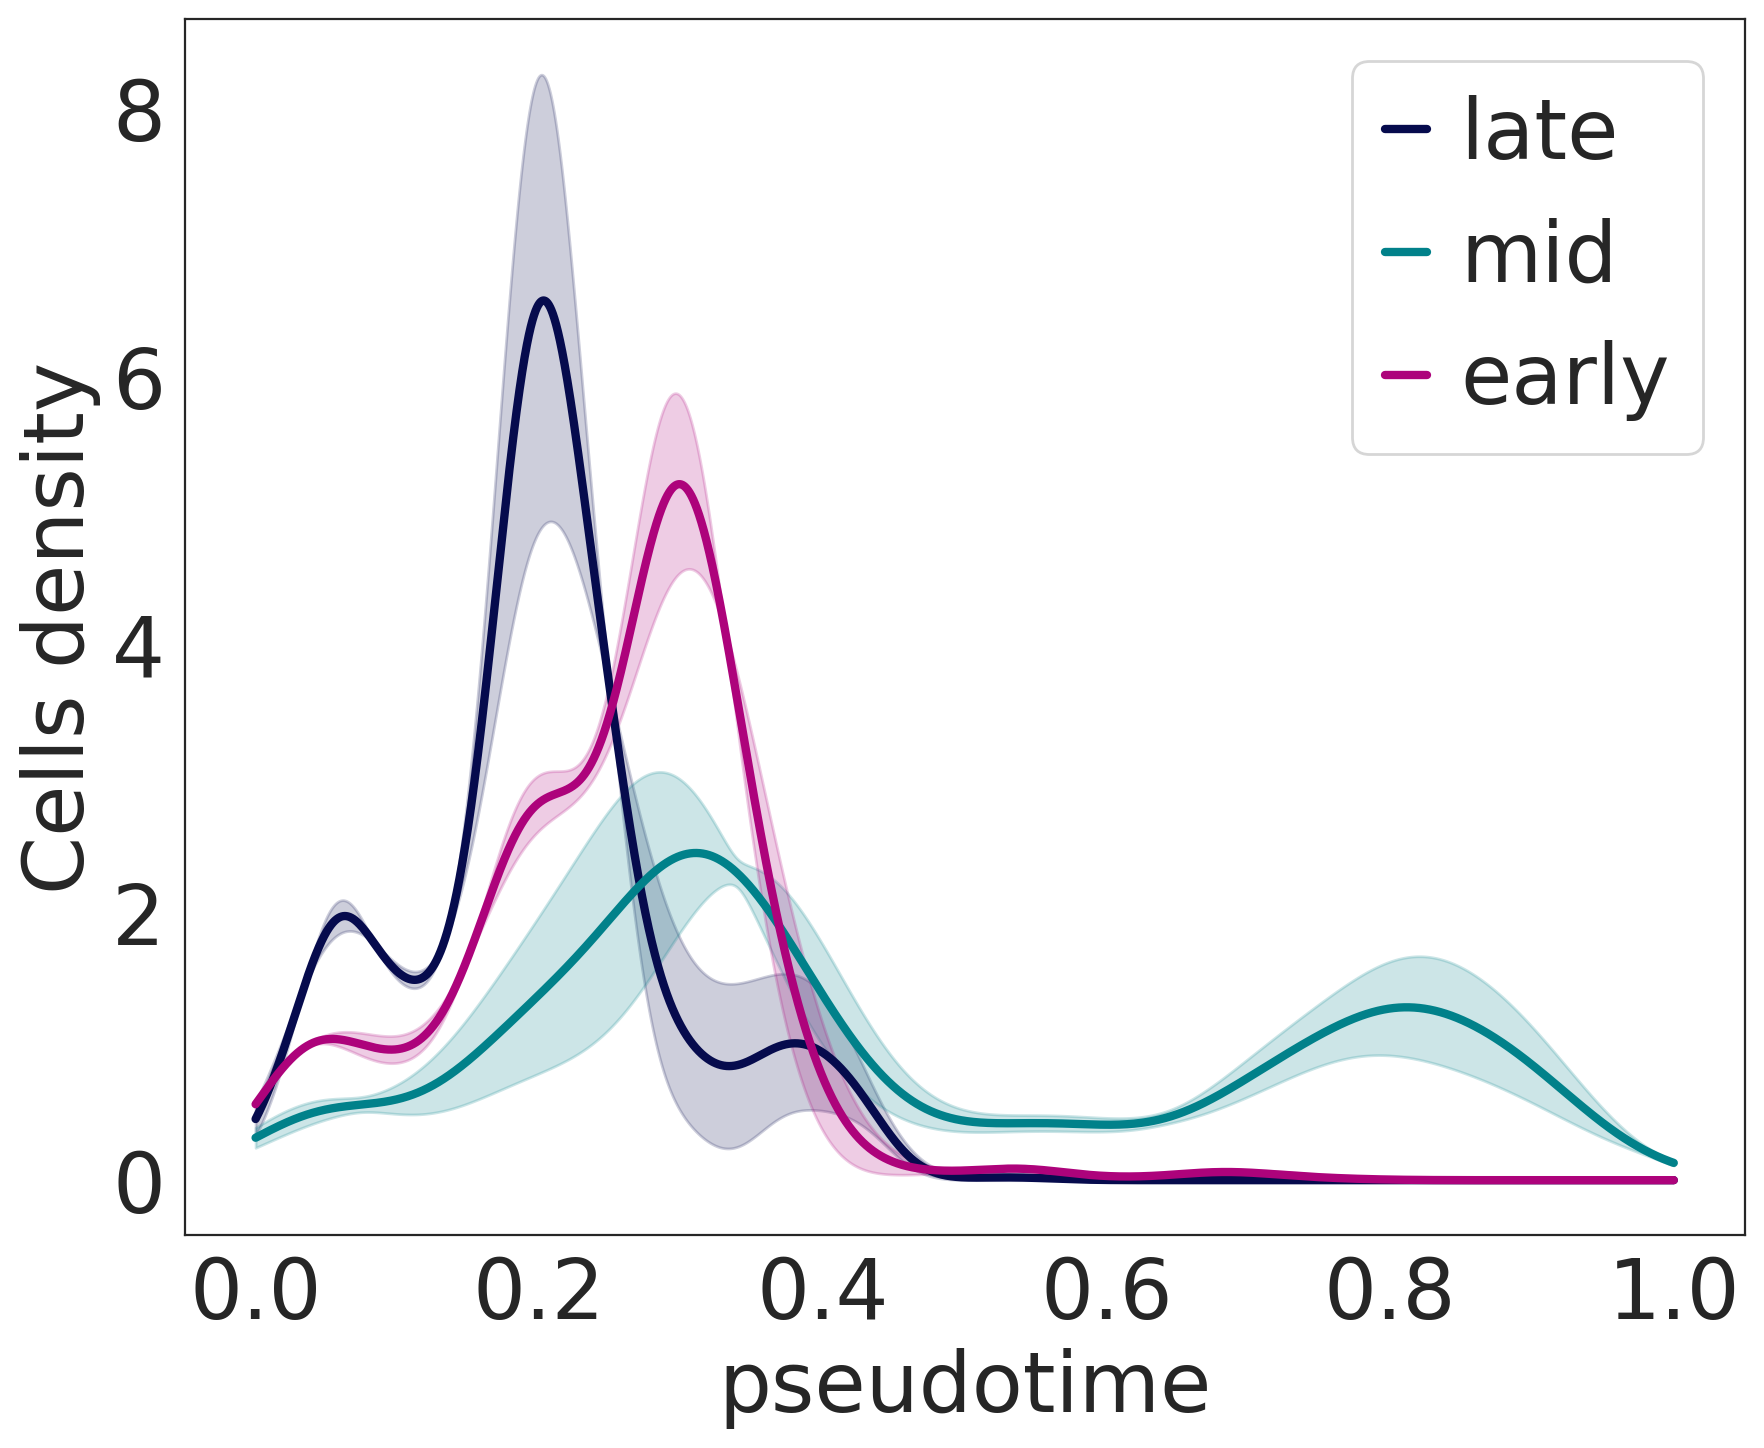

In [18]:
#errors by dataset
for Stage in adataBranch.obs["stage"].unique(): 
    StageLT = adataBranch.obs[adataBranch.obs["stage"] == Stage]
    
    StageLT_smoothed = pd.DataFrame(index=np.linspace(0, 1, 10000))
    for dataset in StageLT["dataset"].unique():
        datasetLT = StageLT.loc[StageLT["dataset"] == dataset,timeCov]
        _bandwidth = round((datasetLT.max() - datasetLT.min()) * binWidthRate, 2)

        KernelData = datasetLT

        
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(0, 1, 10000)[:, np.newaxis]

        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        
        StageLT_smoothed[dataset] = Y
        
    StageLT_smoothed["dpt_cut"] = StageLT_smoothed.index.tolist()
        
    # Calculate error and mean on smoothe values ()

    StageLT_smoothed["mean"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].mean(axis =1)
    StageLT_smoothed["stdev"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].std(axis =1)
    StageLT_smoothed["errMin"] = StageLT_smoothed["mean"] - StageLT_smoothed["stdev"]
    StageLT_smoothed["errMax"] = StageLT_smoothed["mean"] + StageLT_smoothed["stdev"]
    StageLT_smoothed["errMin"] = np.where(StageLT_smoothed["errMin"] < 0, 0, StageLT_smoothed["errMin"])
    
    plt.plot(StageLT_smoothed["dpt_cut"], StageLT_smoothed["mean"], '-', label =Stage,linewidth = 3,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["stage_colors"]))[Stage])
    plt.fill_between(StageLT_smoothed["dpt_cut"], StageLT_smoothed["errMin"], StageLT_smoothed["errMax"] , alpha=0.2,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["stage_colors"]))[Stage])
    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)

    plt.ylabel('Cells density', size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.dpt."+branchTag+".svg")

 

## By paradigm

In [19]:
cov = "type"

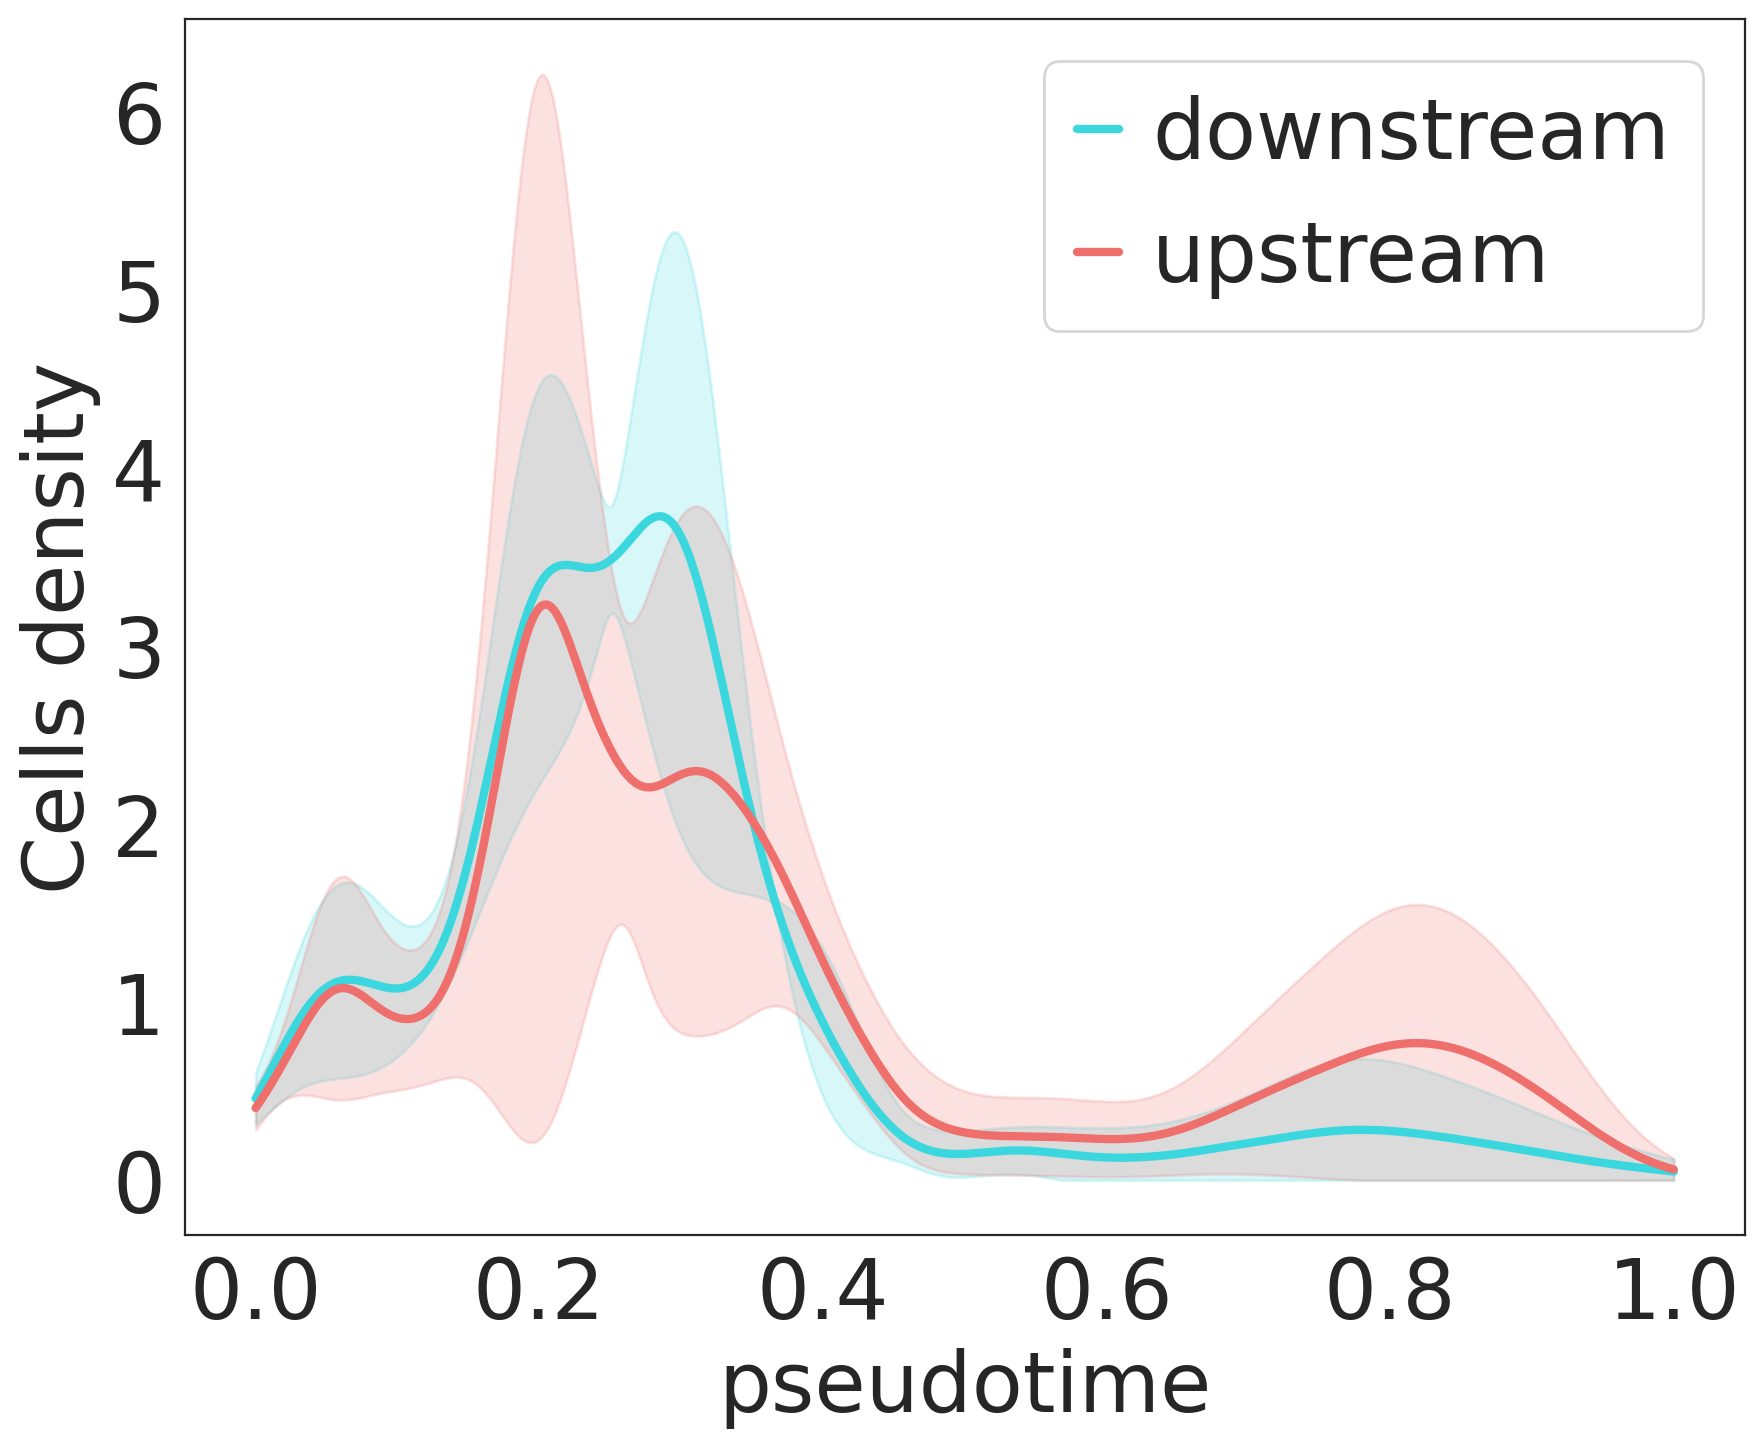

In [20]:
#with errors by dataset
for Stage in adataBranch.obs["type"].unique(): 
    StageLT = adataBranch.obs[adataBranch.obs["type"] == Stage]
    
    StageLT_smoothed = pd.DataFrame(index=np.linspace(0, 1, 10000))
    for dataset in StageLT["dataset"].unique():
        datasetLT = StageLT.loc[StageLT["dataset"] == dataset,timeCov]
        _bandwidth = round((datasetLT.max() - datasetLT.min()) * binWidthRate, 2)
 
        KernelData = datasetLT

        
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(0, 1, 10000)[:, np.newaxis]

        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        
        StageLT_smoothed[dataset] = Y
        
    StageLT_smoothed["dpt_cut"] = StageLT_smoothed.index.tolist()
        
    # Calculate error and mean on smoothe values ()

    StageLT_smoothed["mean"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].mean(axis =1)
    StageLT_smoothed["stdev"] = StageLT_smoothed[[i for i in StageLT_smoothed.columns if i not in ['dpt_cut','stdev']]].std(axis =1)
    StageLT_smoothed["errMin"] = StageLT_smoothed["mean"] - StageLT_smoothed["stdev"]
    StageLT_smoothed["errMax"] = StageLT_smoothed["mean"] + StageLT_smoothed["stdev"]
    StageLT_smoothed["errMin"] = np.where(StageLT_smoothed["errMin"] < 0, 0, StageLT_smoothed["errMin"])
    
    plt.plot(StageLT_smoothed["dpt_cut"], StageLT_smoothed["mean"], '-', label =Stage,linewidth = 3,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["type_colors"]))[Stage])
    plt.fill_between(StageLT_smoothed["dpt_cut"], StageLT_smoothed["errMin"], StageLT_smoothed["errMax"] , alpha=0.2,color = dict(zip(adataBranch.obs[cov].cat.categories.tolist(),adataBranch.uns["type_colors"]))[Stage])

    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)

    plt.ylabel('Cells density', size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.Up_vs_Down.dpt."+branchTag+".svg")

 

In [21]:
figDir+"/8_LineageFigures.Up_vs_Down.dpt."+branchTag+".svg"

'./figures/8_LineageFigures.Up_vs_Down.dpt.Cajal.svg'

## Explore Genotypes

In [22]:
#######---original adata ------- Load Original adata and plot uncorrected PCA and original compositions

sc.settings.verbosity = 0 


adataInitPCA = adataBranch.copy()


compositions = pd.DataFrame(adataInitPCA.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", 
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataInitPCA.obs["cellID_newName"].cat.categories, adataInitPCA.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()


### Downsampling loops

In [23]:
ReproducibilityDF = pd.DataFrame() 
ReproducibilityRaw = pd.DataFrame() 


adataInitPCA = adataInitPCA[adataInitPCA.obs["stage"].isin(MultiTPTstages)]
#Remove genotypes not in all timepoints
GoodIDs = pd.crosstab(adataInitPCA.obs.cellID_newName,adataInitPCA.obs.stage ) > min_cells
GoodIDs = GoodIDs[GoodIDs.sum(axis =1) == len(adataInitPCA.obs["stage"].unique())].index.tolist()
adataInitPCA = adataInitPCA[adataInitPCA.obs.cellID_newName.isin(GoodIDs)]
    
compositions = pd.DataFrame(adataInitPCA.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", title="Balance Before each loop",
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataInitPCA.obs["cellID_newName"].cat.categories, adataInitPCA.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()

    
for seed in range(ResamplingIterations):
    random.seed(seed)
    
    adataGenotypes = adataInitPCA.copy()


    #Subset timepoint if needed
    MinCells = pd.crosstab(adataGenotypes.obs.cellID_newName,adataGenotypes.obs.stage ) 
    MinCells = MinCells.min().to_dict()

    sampledBCs = []
    for stage in adataGenotypes.obs.stage.unique():
        samplingSize = MinCells[stage]
        sampledBCsStage = [ random.sample(adataGenotypes[(adataGenotypes.obs["stage"] == stage) & (adataGenotypes.obs["cellID_newName"] == ID)].obs_names.tolist() ,samplingSize) for ID in adataGenotypes.obs["cellID_newName"].unique().tolist()  ]
        sampledBCsStage = [item for sublist in sampledBCsStage for item in sublist]
        sampledBCs = sampledBCs + sampledBCsStage

    adataGenotypes = adataGenotypes[sampledBCs]
    
    #Trim extreme values
#     trimExtremes = [0.01,.99]
#     minDPT, maxDPT = np.quantile(adataGenotypes.obs["pc1"], trimExtremes)
#     adataGenotypes = adataGenotypes[(adataGenotypes.obs["pc1"] > minDPT) & (adataGenotypes.obs["pc1"] < maxDPT)]
    
    _bandwidth = round((adataGenotypes.obs["dpt_pseudotime"].max() - adataGenotypes.obs["dpt_pseudotime"].min()) * binWidthRate, 2)
    seedPseudotime = pd.DataFrame()
    seedPseudotimeRaw = pd.DataFrame()

    for cellID in adataGenotypes.obs["cellID_newName"].unique(): 
        LocalPseudotime = pd.DataFrame()
        LocalPseudotimeRaw = pd.DataFrame()
        KernelData = adataGenotypes.obs.loc[adataBranch.obs["cellID_newName"] == cellID, "dpt_pseudotime"]
        X = KernelData.values[:, np.newaxis]
        X_plot = np.linspace(adataGenotypes.obs["dpt_pseudotime"].min(), adataGenotypes.obs["dpt_pseudotime"].max(), 10000)[:, np.newaxis]
        # Pick bandwidht
        kde_Calc = KernelDensity(kernel="gaussian", bandwidth=_bandwidth).fit(X)
        Y=np.exp(kde_Calc.score_samples(X_plot))
        LocalPseudotime[seed] = Y
        LocalPseudotime["cellID"] = cellID
        LocalPseudotime["x"] = X_plot.flatten()
        seedPseudotime = pd.concat([seedPseudotime,LocalPseudotime ], ignore_index=True, axis = 0)
        #Raw values non smoothed
        LocalPseudotimeRaw[seed] = KernelData.tolist()
        LocalPseudotimeRaw["cellID"] = cellID
        seedPseudotimeRaw = pd.concat([seedPseudotimeRaw,LocalPseudotimeRaw], ignore_index=True)
    if "cellID" in ReproducibilityDF.columns:
        ReproducibilityDF = pd.concat([seedPseudotime[seed], ReproducibilityDF], axis = 1)
        ReproducibilityRaw = pd.concat([seedPseudotimeRaw[seed], ReproducibilityRaw], axis = 1)
    else:
        ReproducibilityDF = pd.concat([ReproducibilityDF, seedPseudotime], axis =1 )
        ReproducibilityRaw = pd.concat([ReproducibilityRaw, seedPseudotimeRaw], axis =1 )
 
        
        
compositions = pd.DataFrame(adataGenotypes.obs.groupby(["stage","cellID_newName"]).size())
compositions = compositions.reset_index().rename(columns={0:"number_of_cells"})
fig = px.bar(compositions, x="stage", y="number_of_cells", color="cellID_newName", title="Balance Operated whithin each loop",
             category_orders={"stage":["early","mid","late"]}, height=800,width=1000, template="plotly_white",
             color_discrete_map = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories, adataGenotypes.uns["cellID_newName_colors"])))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=1)

fig.show()
        

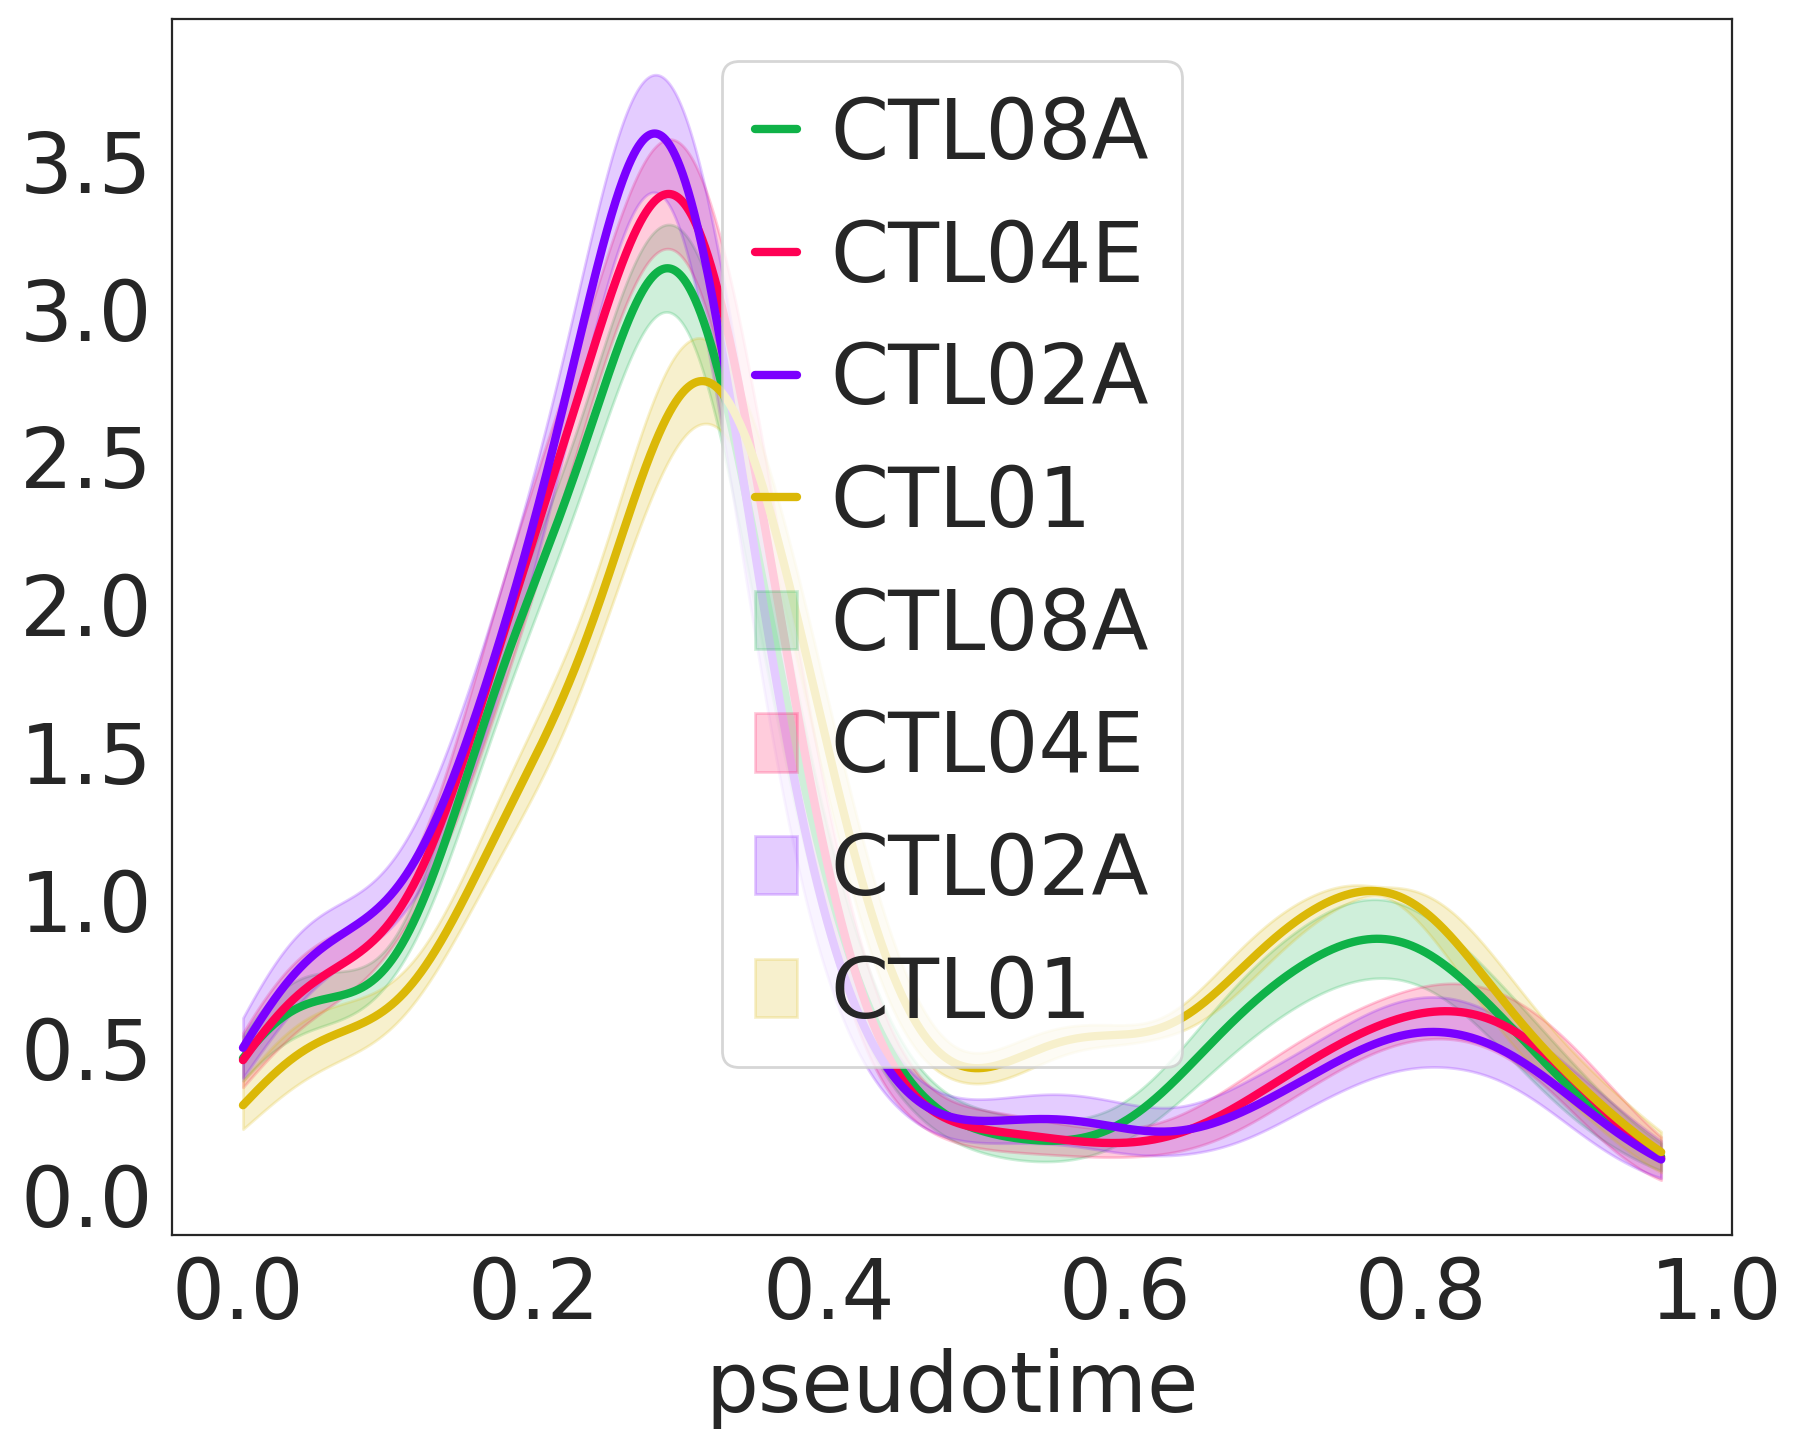

In [26]:

plotDF = ReproducibilityDF.copy()

plotDF["std"] = plotDF[[c for c in plotDF.columns if c not in ["x","cellID","std","mean",'max','min']]].std(axis =1)

plotDF["mean"] = plotDF[[c for c in plotDF.columns if c not in ["x","cellID","std","mean",'max','min']]].mean(axis =1)
plotDF["max"] = plotDF["mean"]+plotDF["std"]
plotDF["min"] = plotDF["mean"]-plotDF["std"]

for g in plotDF.cellID.unique():
    plotDFID = plotDF[plotDF.cellID == g]
    plt.plot(plotDFID["x"], plotDFID["mean"], '-',
             label =g,
             color = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories.tolist(),adataGenotypes.uns["cellID_newName_colors"]))[g],
             linewidth = 3)
    plt.fill_between(plotDFID["x"], plotDFID["min"], plotDFID["max"] , 
                     alpha=0.2,label=g,
                     color = dict(zip(adataGenotypes.obs["cellID_newName"].cat.categories.tolist(),adataGenotypes.uns["cellID_newName_colors"]))[g])

    plt.xlabel('pseudotime', size=30)
    plt.xticks(size=30)
    plt.yticks(size=30)
    plt.legend(prop={'size': 30})
    plt.savefig(figDir+"/8_LineageFigures.Genotypes."+branchTag+".svg")


# Tradeseq within lineage

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor white
dotSize 20


In [25]:
obs = adataBranch.obs
obsm = adataBranch.obsm


adataTradeseq = sc.read_h5ad(outdir+'/adatas/MultiplexingPreprocessing_unscaled.h5ad')[obs.index]
#Sample extra genes to ensure fair unbyased normalization
ExtraNormGenes = random.sample(adataTradeseq.var_names[~adataTradeseq.var_names.isin(HVGs)].tolist(), len(HVGs.tolist()))
adataTradeseq = adataTradeseq[:,HVGs.tolist()+ExtraNormGenes]

adataTradeseq.obs = obs.loc[adataTradeseq.obs_names]
adataTradeseq = adataTradeseq[:,~adataTradeseq.var_names.str.startswith('MT-')]
adataTradeseq = adataTradeseq[:,~adataTradeseq.var_names.str.startswith(("RPS","RPL"))]
adataTradeseq.obsm = obsm
adataTradeseq.uns["leidenAnnotated_colors"] =  adataBranch[adataTradeseq.obs_names].uns["leidenAnnotated_colors"]


#Trim extreme values of DPT (for potentially low amount of cells)
trimExtremes = [0.01,.99]
minDPT, maxDPT = np.quantile(adataTradeseq.obs["dpt_pseudotime"], trimExtremes)
adataTradeseq = adataTradeseq[(adataTradeseq.obs["dpt_pseudotime"] > minDPT) & (adataTradeseq.obs["dpt_pseudotime"] < maxDPT)]

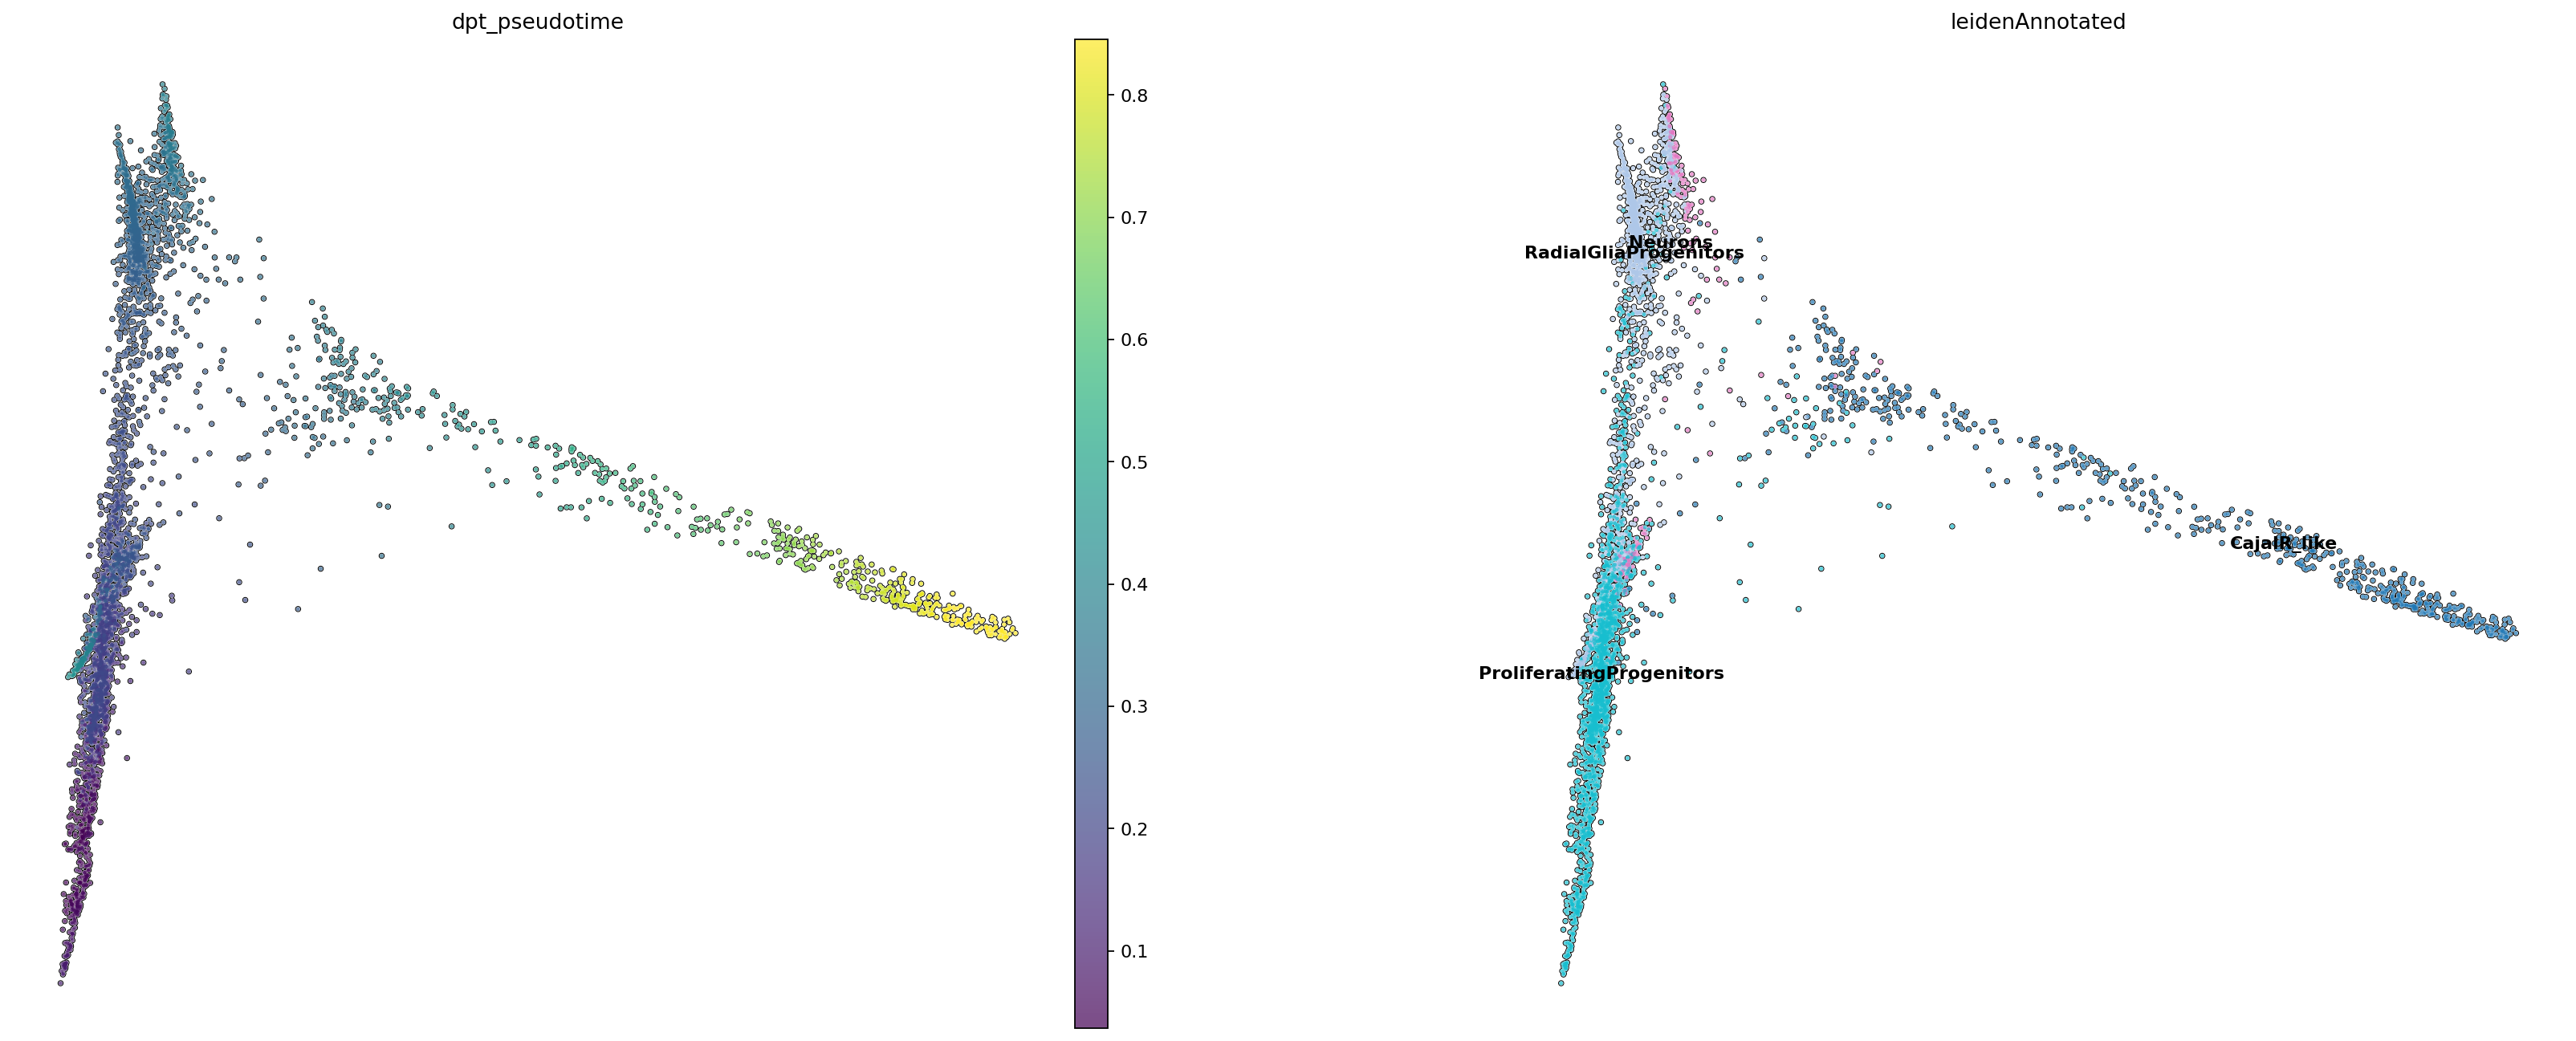

In [26]:

sc.pl.diffmap(adataTradeseq, color = ["dpt_pseudotime","leidenAnnotated"],
           size = rcParamsDict["dotSize"],add_outline=True, outline_width=(0.2, 0.05), vmin='p2',vmax='p98', frameon=False, wspace=.3, legend_loc="on data")


In [27]:
adataTradeseq.obs[endpoint] = 1

In [28]:
cellWeights = adataTradeseq.obs[endpoint]
cellWeights = np.matrix(cellWeights.to_numpy()).T


pseudotime = adataTradeseq.obs["dpt_pseudotime"]
pseudotime = np.matrix(pseudotime.to_numpy()).T



# Transpose needed!
counts = adataTradeseq.X.T.todense()
counts = counts + abs(counts.min())

varnames = adataTradeseq.var_names.tolist()

In [29]:
import anndata2ri
import rpy2
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [30]:
%%R -i tradeSeqUtilsPath

source(tradeSeqUtilsPath)


In [31]:
%%R -i cellWeights -i pseudotime -i counts -i varnames
set.seed(8)

library(tradeSeq)
library(ggplot2)


w <- as.matrix(cellWeights)
dpt <- as.matrix(pseudotime)
cMatrix <- as.matrix(counts)


gamObj <- fitGAM(cMatrix, verbose = TRUE, pseudotime = dpt, cellWeights = w, nknots = 8, sce=FALSE)
names(gamObj) <- varnames


  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18m 57s


In [32]:
%%R -i tradeSeqUtilsPath

source(tradeSeqUtilsPath)


In [33]:
dptseq = np.linspace(pseudotime.min(),pseudotime.max(), 5)
nGenes = 2

leidenCols = dict(zip(adataTradeseq.obs.leidenAnnotated.cat.categories, adataTradeseq.uns["leidenAnnotated_colors"]))

In [34]:
%%R -i nGenes -o merged


startRes <- startVsEndTest(gamObj)
startResSS <- startRes[startRes$pvalue == 0,]
startResGenesPositive <- rownames(head(startResSS[order(startResSS$logFClineage1, decreasing = TRUE),],nGenes))
print(startResGenesPositive)
startResGenesNegatives <- rownames(tail(startResSS[order(startResSS$logFClineage1, decreasing = TRUE),],nGenes))
print(startResGenesNegatives)


assoRes <- associationTest(gamObj)
merged <- merge(startRes, assoRes, by=0, all=FALSE)

[1] "FGF5"    "GALNT15"
[1] "SOX2"  "TOP2A"


In [35]:
merged["rankstartRes"] = abs(merged["logFClineage1"]).rank()
merged["rankassoRes"] = abs(merged["meanLogFC"]).rank()
merged["rankedDiff"] = merged["rankassoRes"] - merged["rankstartRes"]
#merged = merged[abs(merged["meanLogFC"]) > 2]
merged = merged.sort_values("rankedDiff", ascending = False)
merged["FinalRank"] =  range(merged.shape[0])
merged.index = merged["Row.names"].tolist()
Transient = merged.head(nGenes).index.tolist()
Transient

['SALL4', 'HTD2']

In [36]:
%%R -i Transient -o assoResSSPandas

CombinedList <- c(startResGenesPositive,startResGenesNegatives,Transient)

datalist <- list()
for (g in CombinedList){
    
    localModel <- gamObj[[g]]    
    data <- localModel$model    
    y <- data$y
    nCurves <- length(localModel$smooth)

    for (jj in seq_len(nCurves)) {
        df <- .getPredictRangeDf(localModel$model, jj, nPoints = 100)
        yhat <- predict(localModel, newdata = df, type = "response")

        Newframe <- data.frame("fittedCounts" = yhat)
        colnames(Newframe) <- c(paste0("fittedCounts.",g))

        datalist[[paste(g,jj)]] <- Newframe

        
        

    }

}

assoResSSPandas =  do.call(cbind, datalist)


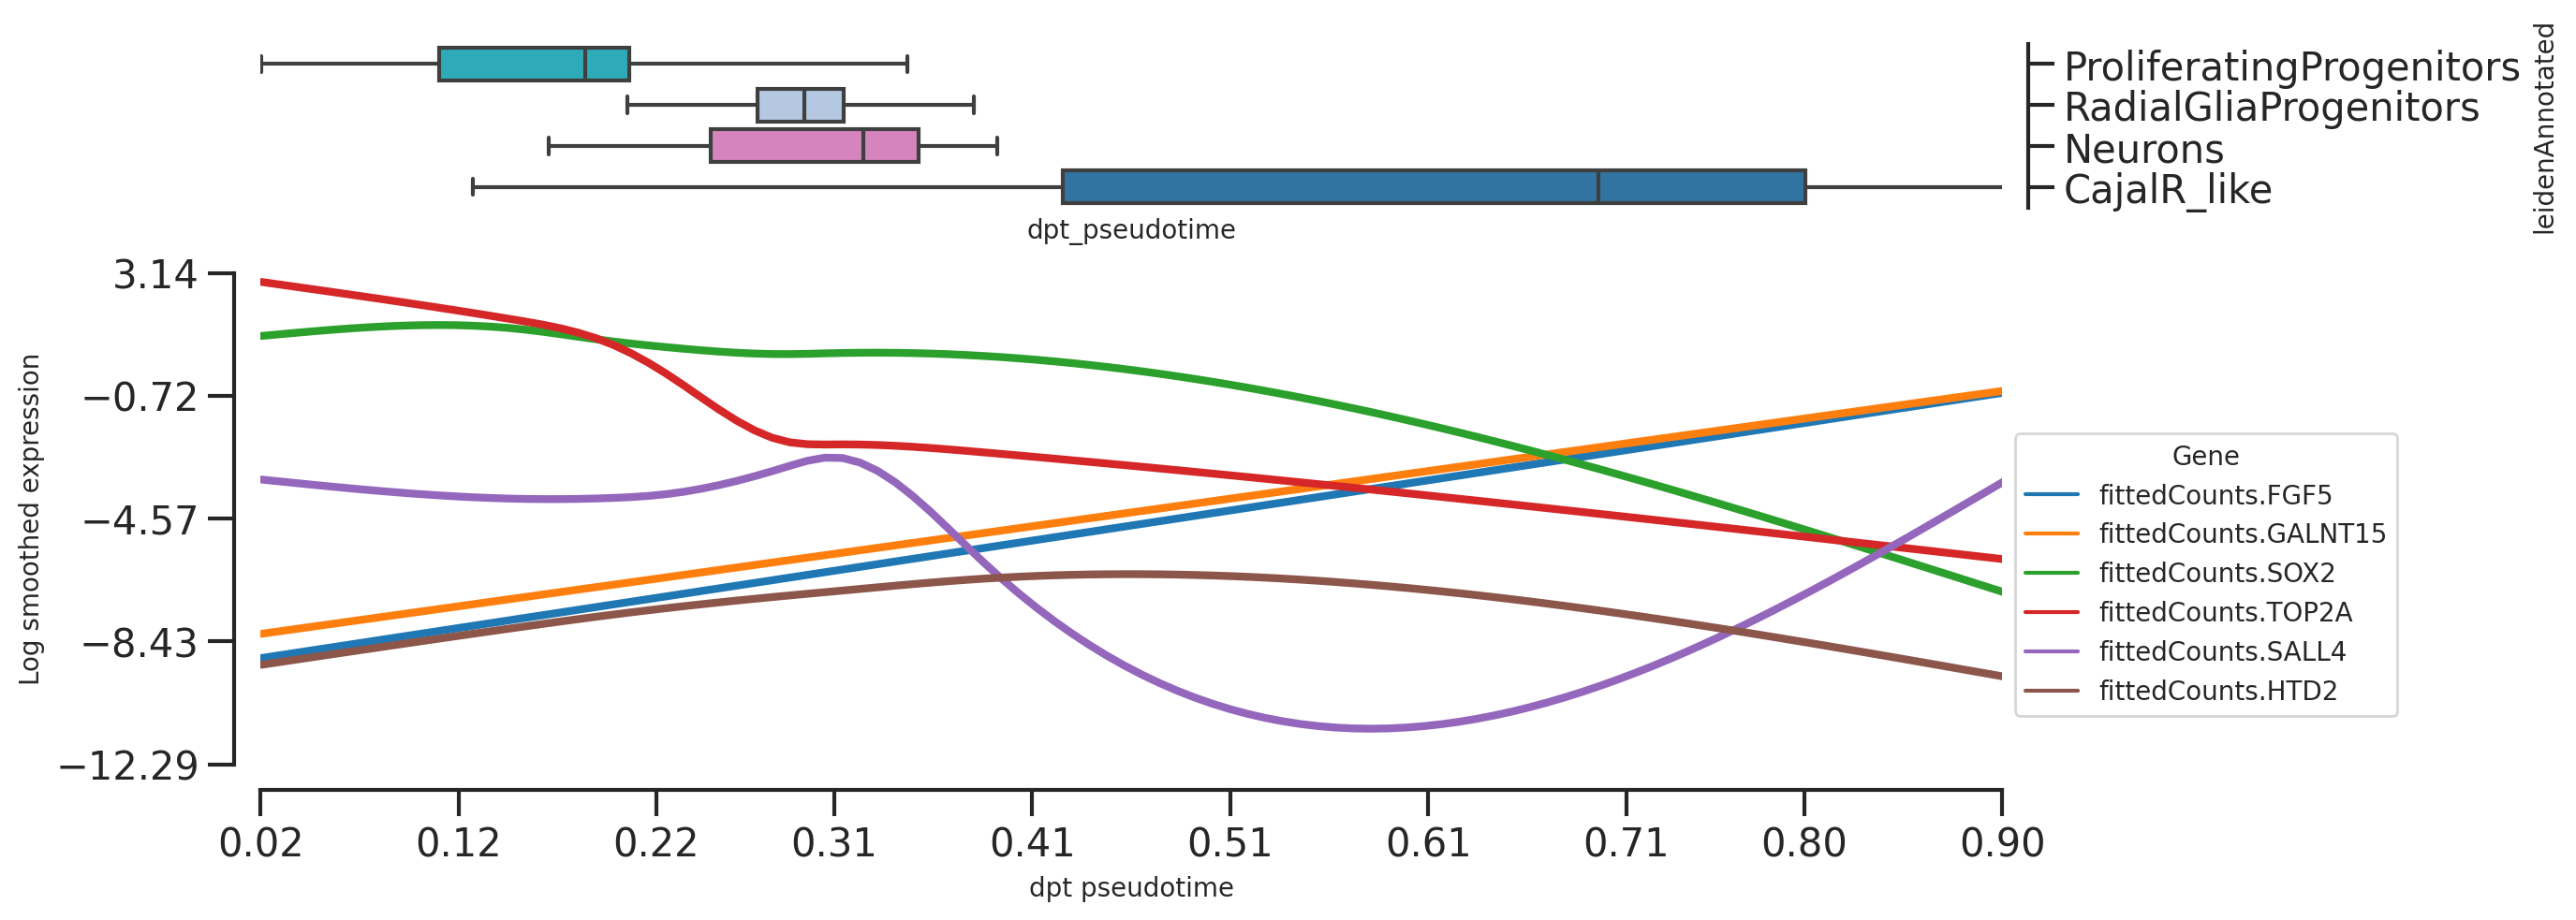

In [37]:
#Curatedmarkerslist = CuratedmarkersDF.loc[CuratedmarkersDF.score > 1,"name"].tolist()
#CuratedmarkersDF = pd.read_csv(markers, header=None, sep = "\t", names=["name","area","score"])
#Curatedmarkerslist = CuratedmarkersDF.loc[CuratedmarkersDF.score >= 1,"name"].tolist()

##############################


###################à
plt.rcdefaults()

sns.set_style("ticks", {'axes.grid' : False})


fig, axes = plt.subplots(2,1, figsize=(12,5),sharex=True, 
                         gridspec_kw={'height_ratios': [1, 3]})

sns.boxplot(data=adataTradeseq.obs, x="dpt_pseudotime", y="leidenAnnotated", ax = axes[0],
            palette=leidenCols,
            showfliers=False,order=leidenOrder)

    

    
    


#fig, axes = plt.subplots(2,1, figsize=(10,5),sharex=True, 
#                         gridspec_kw={'height_ratios': [1, 2]})

#sns.histplot(data=adataTradeseq.obs, x="dpt_pseudotime", hue="leidenAnnotated", ax=axes[0])

# sns.histplot(data=adataTradeseq.obs, x="dpt_pseudotime", hue="leidenAnnotated", ax=axes[0],bins=100,
#               palette=dict(zip(adata.obs.leidenAnnotated.cat.categories, adata.uns["leidenAnnotated_colors"])), alpha=.5)




SmoothedExpr = assoResSSPandas.copy()
SmoothedExpr["pseudotime"] = SmoothedExpr.index.tolist()      
SmoothedExpr["pseudotime"] =  np.linspace(pseudotime.min(),pseudotime.max(), 100)
SmoothedExpr = SmoothedExpr.melt("pseudotime")
SmoothedExpr["value"] = np.log(SmoothedExpr["value"])


#TrimExtremes


sns.lineplot(data=SmoothedExpr, x="pseudotime", y="value", hue= "variable",  linewidth=3, ax=axes[1])
#axes[1].lines[1].set_linestyle("--")





dptAxis = np.linspace(SmoothedExpr.pseudotime.min(), SmoothedExpr.pseudotime.max(), 10).round(2)      
ylimits = np.array([SmoothedExpr.value.min()-abs((SmoothedExpr.value.min()*.1)), 
                    SmoothedExpr.value.max()+abs((SmoothedExpr.value.max()*.1))]).round(2)
exprAxis = np.linspace(ylimits.min(), ylimits.max(),5).round(2)


axes[1].set_xlim([dptAxis.min(), dptAxis.max()])
axes[1].set_ylim(ylimits)


axes[0].yaxis.tick_right()
axes[0].spines[['left', 'top','bottom']].set_visible(False)
axes[0].spines['right'].set_linewidth(1.5)
axes[0].tick_params(axis='y', which='major', labelsize=15, width=1.5, length=10)
axes[0].tick_params(axis='x', which='major', labelsize=15, width=0, length=10)


axes[1].set_xticks(dptAxis)
axes[1].set_yticks(exprAxis)

axes[1].spines['left'].set_linewidth(1.5)
axes[1].spines['bottom'].set_linewidth(1.5)
axes[1].tick_params(axis='both', which='major', labelsize=15, width=1.5, length=10)
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].xaxis.tick_bottom()
axes[1].yaxis.tick_left()
axes[1].legend(title='Gene', bbox_to_anchor=(1, .7))


sns.despine(ax=axes[1], top=True, right=True, left=False, bottom=False, offset=10, trim=False)
sns.despine(ax=axes[0], top=True, right=False, left=False, bottom=True, offset=10, trim=False)
axes[0].yaxis.set_label_position("right")
axes[0].spines[['left', 'top','bottom']].set_visible(False)

axes[1].set(xlabel='dpt pseudotime', ylabel='Log smoothed expression')



fig.show()
        


fig.savefig(figDir+'/TopGenes.'+branchTag+'.pdf',bbox_inches='tight')